Deconvoluting spatial transcriptomics datasets with Stereoscope
===============================================================

This tutorial shows how to use **Stereoscope** for deconvolution of spatial transcriptomics data.

- [paper]( https://www.nature.com/articles/s42003-020-01247-y)
- code [1](https://docs.scvi-tools.org/en/stable/api/reference/scvi.external.RNAStereoscope.html#scvi.external.RNAStereoscope) and [2](https://docs.scvi-tools.org/en/stable/api/reference/scvi.external.SpatialStereoscope.html#scvi.external.SpatialStereoscope)
- [tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/stereoscope_heart_LV_tutorial.html)

For an in-depth overview of the method, check out the scvi [user guide](https://docs.scvi-tools.org/en/stable/user_guide/models/stereoscope.html?highlight=stereoscope).

Similar (more recent) tools that solve the same problem with more advanced parametrizations are:
- [destvi](https://docs.scvi-tools.org/en/stable/user_guide/models/destvi.html?highlight=destvi)
- [cell2location](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cell2location_lymph_node_spatial_tutorial.html?highlight=cell2location#Mapping-human-lymph-node-cell-types-to-10X-Visium-with-Cell2location)

All model summaries and math notation are taken/adapted from the scvi-tool [documentation](https://docs.scvi-tools.org/en/stable/user_guide/models/stereoscope.html).

if on colab, install packages and download data.

In [1]:
# !pip install scvi-tools
# !pip install squidpy
# !pip install --user scikit-misc
# !wget https://hmgubox2.helmholtz-muenchen.de/index.php/s/Sc5i4YLfxM93T5N/download/univr-spatial.tar.gz
# !tar -xvzf ./univr-spatial.tar.gz

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import anndata as ad
import squidpy as sq


sc.set_figure_params(figsize=(4, 4), frameon=False)

In [3]:
# set path
path = pathlib.Path("./advomics_data_spatial")

Data preparation
----------------

Read in data and standard preprocessing with Scanpy and Umap visualization.

In [4]:
sc_adata = sc.read(path / "dh_sc.h5ad")
sc_adata.var_names_make_unique()
sc.pp.subsample(sc_adata, fraction=0.2, random_state=42)
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.astype(np.float64).copy()
sc_adata = sc_adata[
    sc_adata.obs.Main_cluster_name != "Erythroblasts"
].copy()  # remove Erythroblasts cause they are too few
sc.pp.highly_variable_genes(
    sc_adata, n_top_genes=G, subset=True, layer="counts", flavor="seurat_v3"
)
sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.8/dist-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3']
  warnings.warn(


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


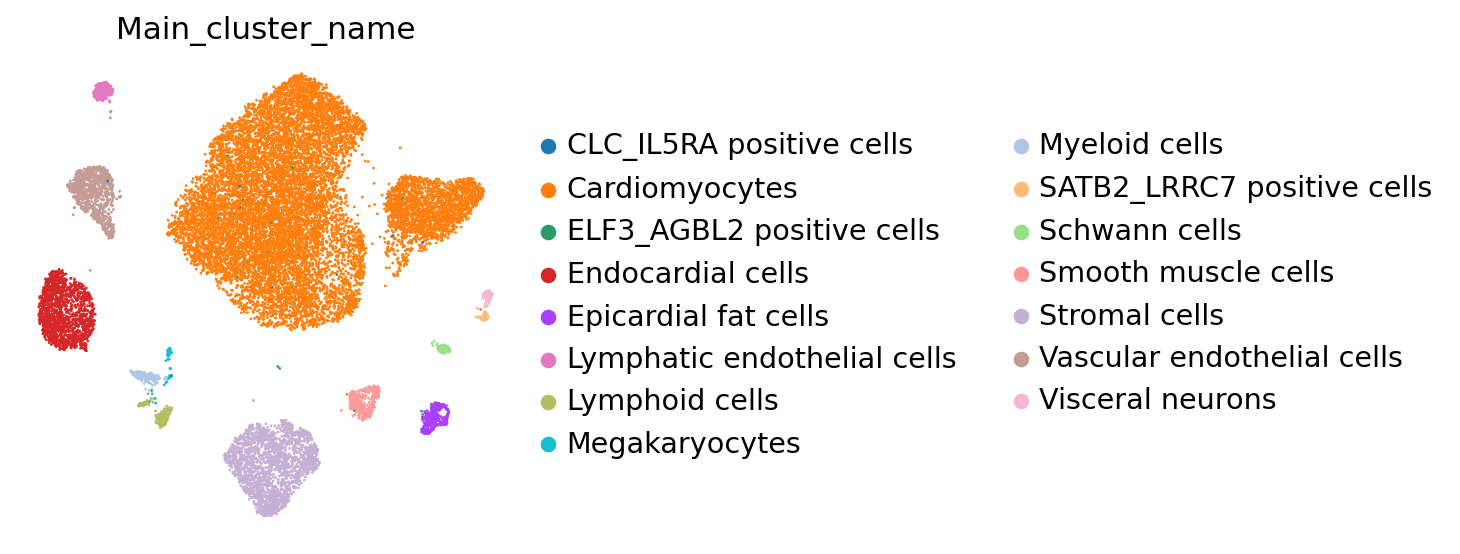

In [5]:
sc.pl.umap(sc_adata, color="Main_cluster_name")

Do the same for the spatial dataset.

In [6]:
st_adata = sc.read(path / "V10F24-105_A1.h5ad")
st_adata.var_names_make_unique()
sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)

In [7]:
st_adata.layers["counts"].max()

7503.0

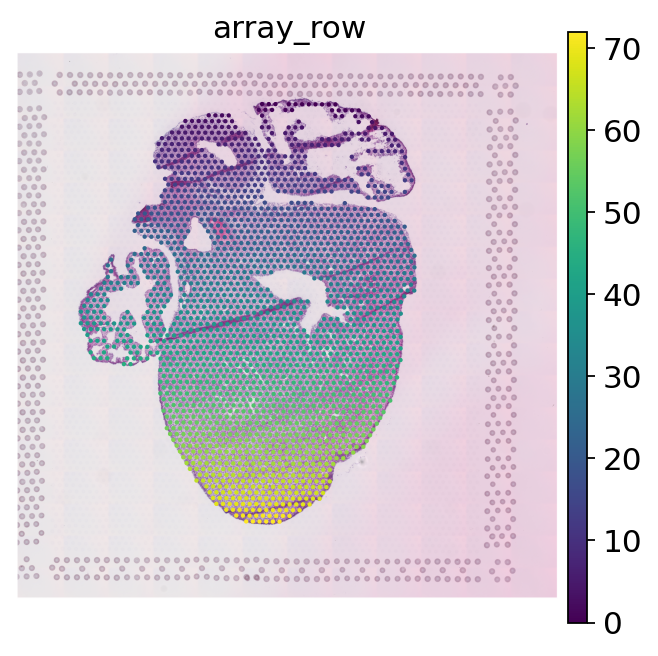

In [8]:
sq.pl.spatial_scatter(st_adata, color="array_row")

Find unique genes between single cell and spatial.

In [9]:
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

## Preliminaries

Stereoscope requires training two latent variable models (LVMs): one for the single-cell reference
dataset and one for the spatial transcriptomics dataset, which incorporates the learned parameters of the
single-cell reference LVM. The first LVM takes in as input a scRNA-seq gene expression matrix of UMI counts
$Y$ with $N$ cells and $G$ genes, along with a vector of cell type labels $\vec{z}$.
Subsequently, the second LVM takes in the learned parameters of the first LVM, along with a spatial gene
expression matrix $X$ with $S$ spots and $G$ genes.

## Generative process

### Single-cell reference LVM

For cell $c$, the LVM assumes an observed discrete cell type label $z_c$ and models
the UMI count observation for a given gene $g$ as a negative binomial distribution. This LVM posits that the observed
UMI counts for cell $c$ and gene $g$ are generated by the following process:

$ y_{gc} \sim NB(s_{c}r_{gz}, p_{g}) $

where $s_c = \sum_{g\in G} y_{gc}$ is the observed library size of the cell,
$r_{gz}$ is the latent rate parameter for the cell type $z_c$ and gene $g$,
and $p_g$ is the latent variable representing the success probability for gene $g$.

Prepare RNAStereoscope model and train.

In [10]:
from scvi.external import RNAStereoscope, SpatialStereoscope

RNAStereoscope.setup_anndata(sc_adata, layer="counts", labels_key="Main_cluster_name")

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


Note, epochs should normally be much higher (>100) but for the purpose of the they were set to 10.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|██████████| 10/10 [00:46<00:00,  4.62s/it, loss=4.28e+04, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:46<00:00,  4.69s/it, loss=4.28e+04, v_num=1]


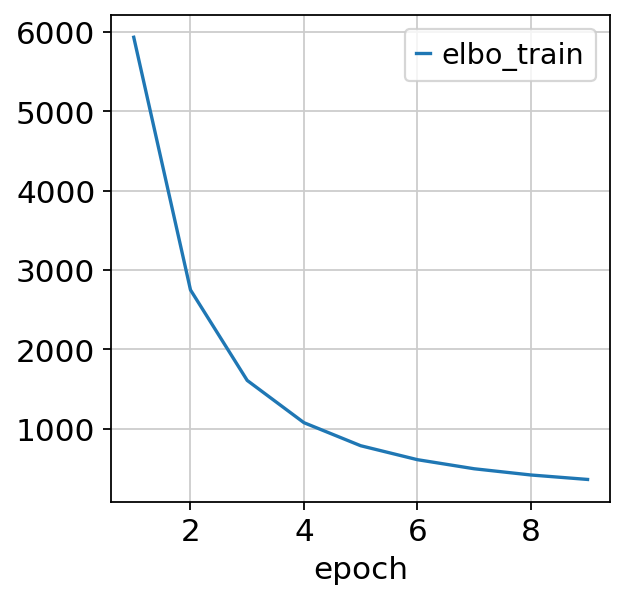

In [11]:
train = True
if train:
    sc_model = RNAStereoscope(sc_adata)
    sc_model.train(max_epochs=10, use_gpu=False)
    sc_model.history["elbo_train"][1:].plot()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", adata=sc_adata)
    print("Loaded RNA model from file!")

Do the same for spatial model.

### Spatial transcriptomics LVM

For the second LVM, we also model the expression counts with a $\mathrm{NegativeBinomial}$. However,
for spatial data, we assume that each spot $s$ has expression $x_s$ composed of a bulk of cell types, with
cell type abundance, $v_{sz}$, for each cell type $z$. We assume that for a given spot $s$ and gene $g$,
the observation is generated by the following process:

$x_{sg} \sim NB(\beta_g\sum_{z\in Z}v_{sz}r_{gz}, p_g)$

where $\beta_g$ is a gene-specific correction term for technical differences.
The parameters $r_{gz}$ and $p_g$ are the learned parameters from the first LVM.

An additional latent variable, $\eta_g$, is incorporated into the aggregated cell expression profile
as a dummy cell type to represent gene specific noise. The dummy cell type's expression profile is distributed
as $\varepsilon_g := \mathrm{Softplus}(\eta_g)$ where $\eta_g \sim \mathrm{Normal}(0, 1)$ to avoid the model
from incorrectly assigning explanatory power to this term.
Like the other cell types, there is an associated cell type abundance parameter $\gamma_s$ associated with $\varepsilon$.

In [12]:
SpatialStereoscope.setup_anndata(st_adata, layer="counts")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s, loss=2.05e+06, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s, loss=2.05e+06, v_num=1]


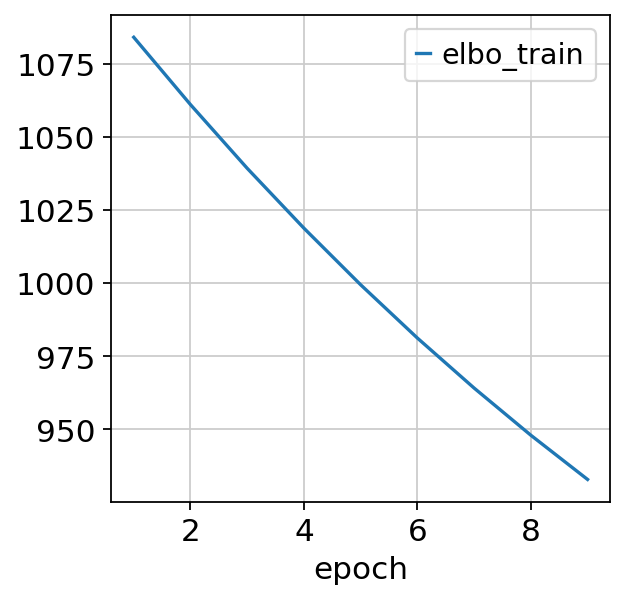

In [13]:
train = True
if train:
    spatial_model = SpatialStereoscope.from_rna_model(
        st_adata, sc_model, layer="counts"
    )
    spatial_model.train(max_epochs=10)
    spatial_model.history["elbo_train"][1:].plot()
    spatial_model.save("stmodel", overwrite=True)
else:
    spatial_model = SpatialStereoscope.load("stmodel", adata=st_adata)
    print("Loaded Spatial model from file!")

Transfer deconvolution to ``adata.obs``.

In [14]:
st_adata.obsm["deconvolution"] = spatial_model.get_proportions()

# also copy as single field in the anndata for visualization
for ct in st_adata.obsm["deconvolution"].columns:
    st_adata.obs[ct] = st_adata.obsm["deconvolution"][ct]

In [15]:
st_adata.obsm["deconvolution"].columns

Index(['CLC_IL5RA positive cells', 'Cardiomyocytes',
       'ELF3_AGBL2 positive cells', 'Endocardial cells',
       'Epicardial fat cells', 'Lymphatic endothelial cells', 'Lymphoid cells',
       'Megakaryocytes', 'Myeloid cells', 'SATB2_LRRC7 positive cells',
       'Schwann cells', 'Smooth muscle cells', 'Stromal cells',
       'Vascular endothelial cells', 'Visceral neurons'],
      dtype='object')

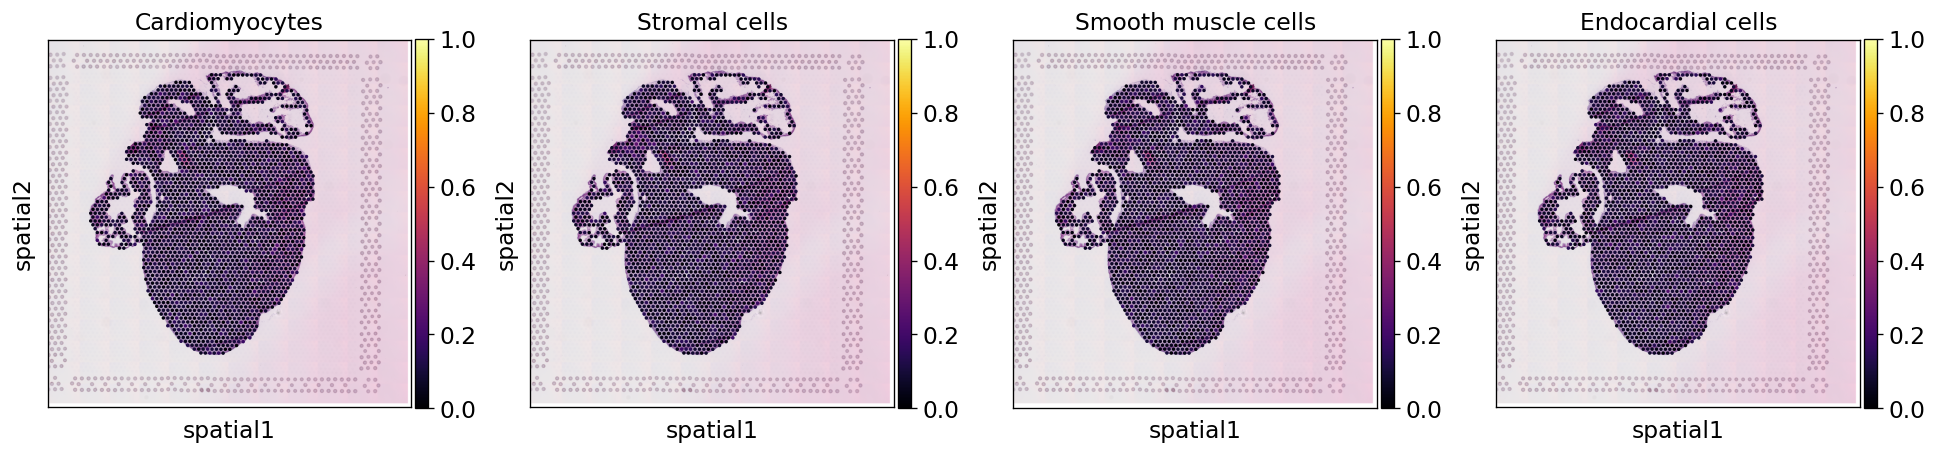

In [16]:
sc.settings.set_figure_params(
    dpi=60, color_map="RdPu", dpi_save=200, vector_friendly=True, format="svg"
)
sq.pl.spatial_scatter(
    st_adata,
    color=[
        "Cardiomyocytes",
        "Stromal cells",
        "Smooth muscle cells",
        "Endocardial cells",
    ],
    size=1.2,
    cmap="inferno",
    vmin=0,
    vmax=1,
)

### Exercise

For the excerise, you can read in one or multiple visium slides with precomputed proportions from either *stereoscope* or from *destvi*, using this line of code:

```python
st_adata = sc.read(path / "V10F24-105_A1_stereoscope.h5ad")
```
just replace `dest_vi` instead of `stereoscope`. 

#### Spatial co-localization
Which cell-types co-localize together? You can find it by computing correlation and plotting it with an heatmap. Check out [sns.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html) and remember that `deconvolution` is saved in adata as a `pd.DataFrame`:
```python
corr_mat = st_adata.obsm["deconvolution"].corr()
```

For correct color labeling you can get a dictionary of the color palette previously visualized with Umap with this:

```python
cols = dict(
    zip(
        sc_adata.obs["Main_cluster_name"].cat.categories,
        sc_adata.uns["Main_cluster_name_colors"],
    )
)
```

<details>
<summary>Hint</summary>
    
```python
import seaborn as sns
corr_mat = st_adata.obsm["deconvolution"].corr()
cols = dict(
    zip(
        sc_adata.obs["Main_cluster_name"].cat.categories,
        sc_adata.uns["Main_cluster_name_colors"],
    )
)
row_colors = [cols[i] for i in corr_mat.index]
col_colors = [cols[i] for i in corr_mat.columns]
sns.clustermap(corr_mat,row_colors=row_colors, col_colors=col_colors, cmap="inferno", vmin=0, vmax=1)
```
    
</details>


#### Cell-type niches
We can use deconvolution results to find clusters of spots that are similar in cell type composition.
To do so, create a new anndata with the deconvolution results as *features*
```python
adata_prop = ad.AnnData(
    st_adata.obsm["deconvolution"].copy(),
    obsm=st_adata.obsm.copy(),
    obs=st_adata.obs.copy(),
    uns=st_adata.uns.copy(),
)
adata_prop.var_names = st_adata.obsm["deconvolution"].columns
```

and run and then visualize standard scanpy clustering. 

<details>
<summary>Hint</summary>
    
```python
adata_prop = ad.AnnData(
    st_adata.obsm["deconvolution"].copy(),
    obsm=st_adata.obsm.copy(),
    obs=st_adata.obs.copy(),
    uns=st_adata.uns.copy(),
)
adata_prop.var_names = st_adata.obsm["deconvolution"].columns

sc.pp.scale(adata_prop)
sc.pp.neighbors(adata_prop)
sc.tl.leiden(adata_prop)

sq.pl.spatial_scatter(adata_prop, color="leiden")
```
    
</details>


How do they relate to previously found clusters?